In [19]:
import pandas as pd

# Wczytanie danych
df = pd.read_csv('sport.csv')

# Wyświetlenie podstawowych informacji
print(df.head())
print(df.info())


   Unnamed: 0  sex        date  age  height  weight discipline  AeT  AnT  \
0           0    1  2023-07-21   45     184    81.0    running  128  157   
1           1    0  2023-08-04   33     171    64.0    running  171  184   
2           2    1  2023-08-04   38     185    72.0    running  157  178   
3           3    1  2023-08-04   37     182    81.0  triathlon  134  176   
4           4    1  2023-08-02   40     175    72.0    running  139  158   

   vo2max  ...  hr_18  la_18  hr_20  la_20  hr_22  la_22   z2   z3   z4   z5  
0    56.3  ...  165.0   12.3    NaN    NaN    NaN    NaN  121  129  149  158  
1    52.8  ...  197.0    NaN    NaN    NaN    NaN    NaN  154  172  178  185  
2    56.2  ...  178.0    3.6    NaN    NaN    NaN    NaN  138  158  167  179  
3    53.3  ...  180.0    NaN    NaN    NaN    NaN    NaN  123  135  162  177  
4    58.7  ...    NaN    NaN    NaN    NaN    NaN    NaN  126  140  152  159  

[5 rows x 38 columns]
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [21]:
df = df.drop(columns=['Unnamed: 0'])


              age      height      weight      vo2max
count  100.000000  100.000000  100.000000  100.000000
mean    38.960000  171.256912   68.323627   39.317685
std     12.703233    9.886570   13.949804    5.042324
min     20.000000  152.737174   36.648953   26.137036
25%     28.750000  163.230480   59.069414   36.523938
50%     38.500000  170.915387   67.716798   39.206899
75%     51.000000  179.021310   79.434347   42.687743
max     59.000000  193.831448  103.889634   51.519583
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     100 non-null    int32  
 1   height  100 non-null    float64
 2   weight  100 non-null    float64
 3   vo2max  100 non-null    float64
dtypes: float64(3), int32(1)
memory usage: 2.9 KB
None


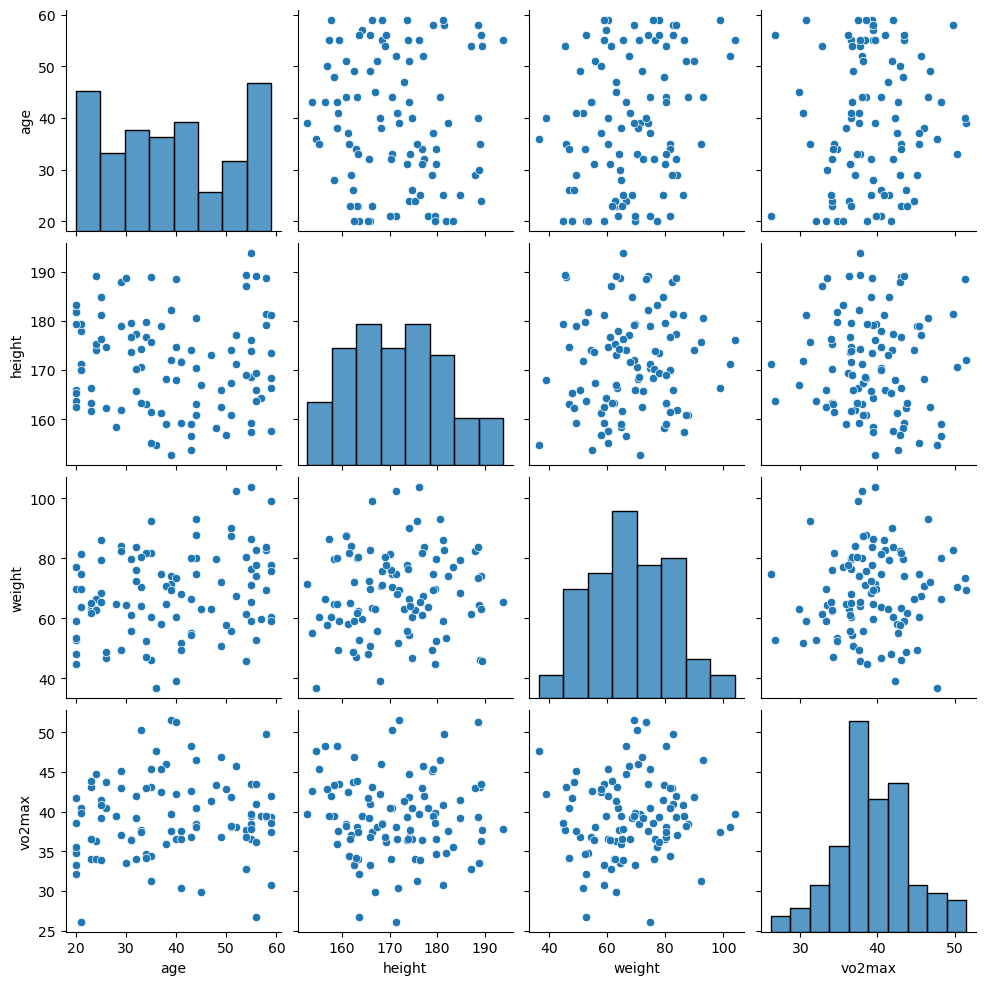

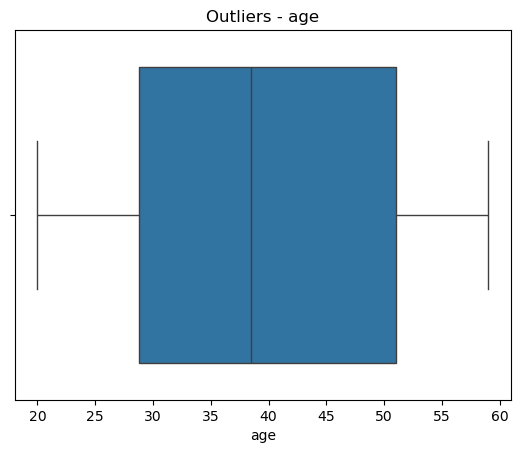

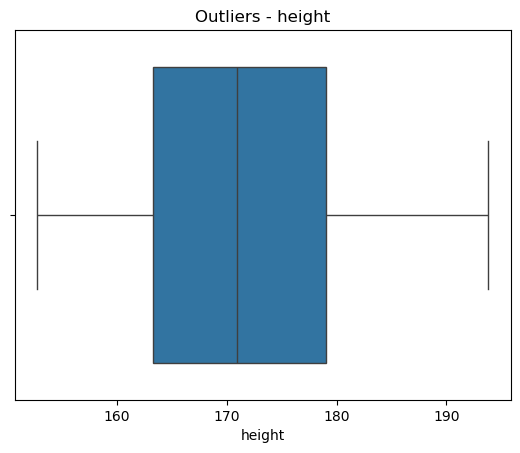

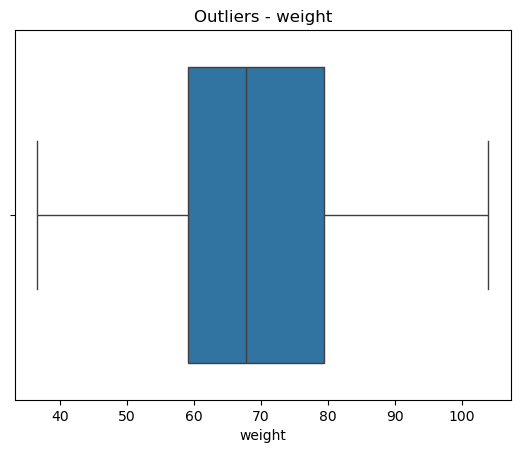

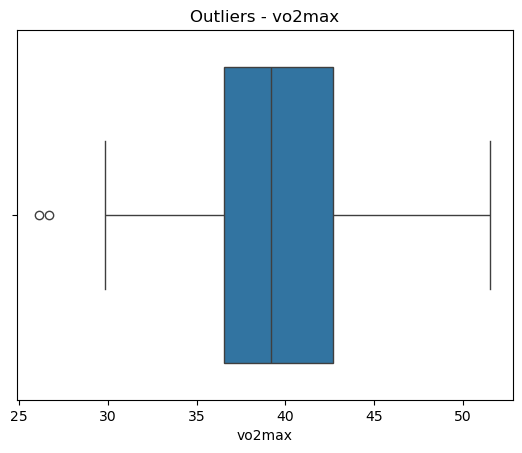

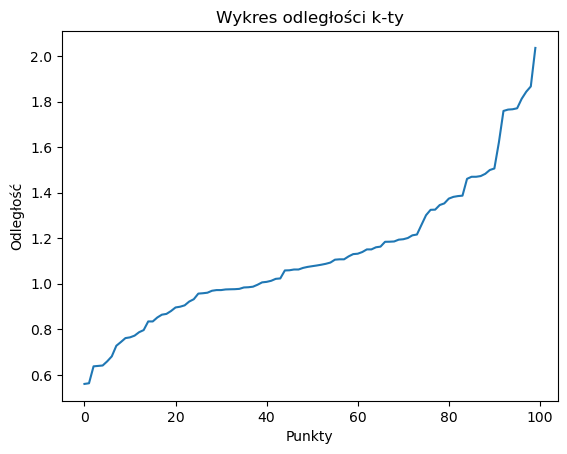

Wykryte klastry: 0
Liczba punktów szumowych: 100


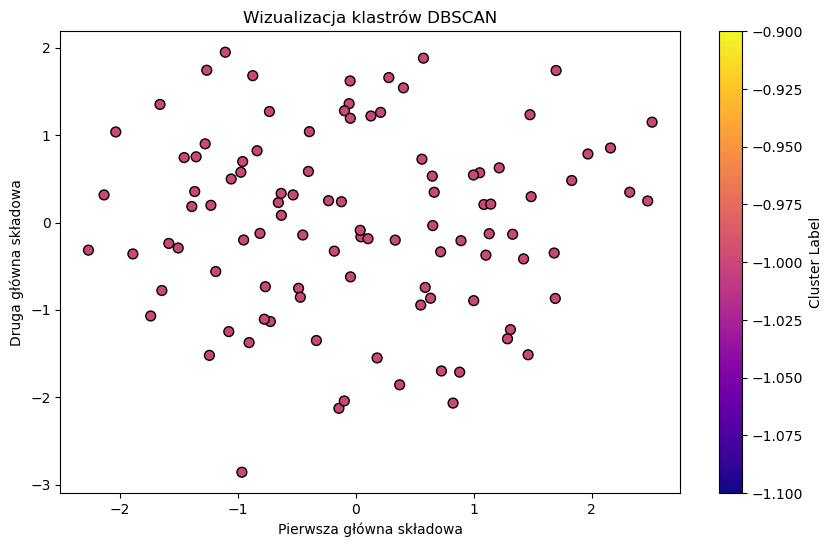

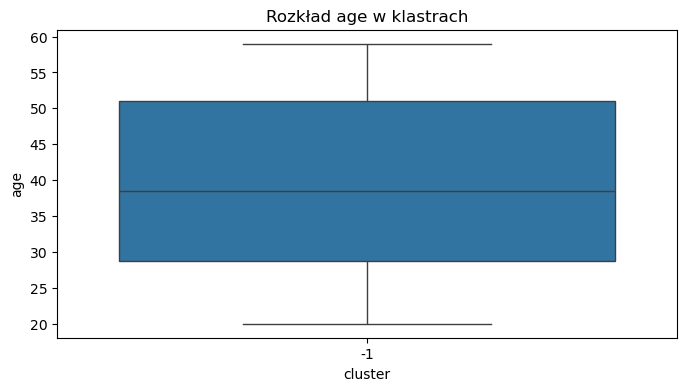

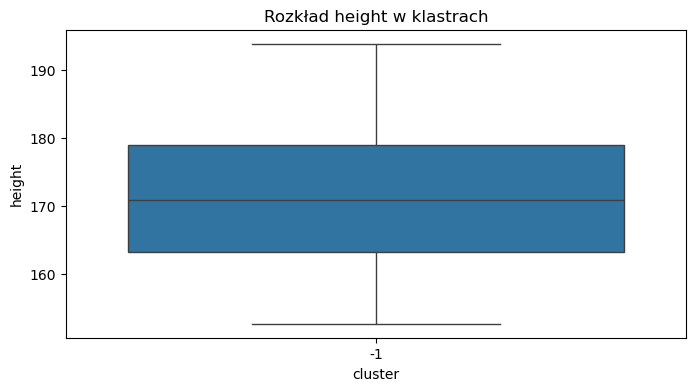

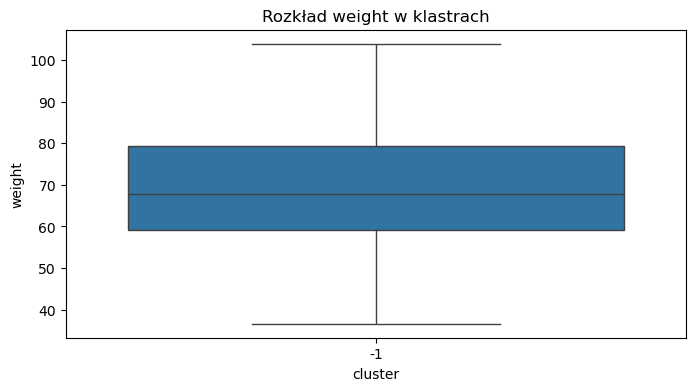

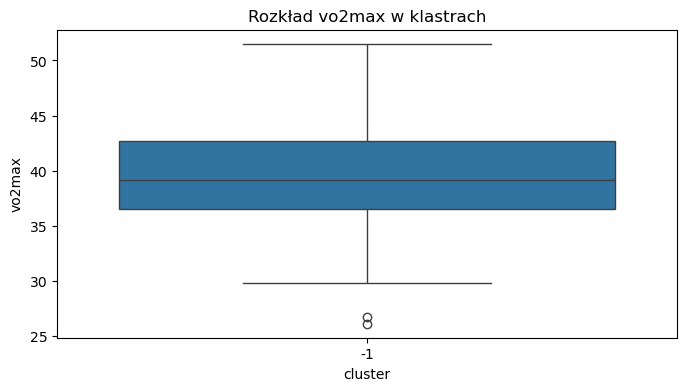

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# Przygotowanie przykładowego datasetu, jeśli nie mamy własnego
# df = pd.read_csv('path_to_your_data.csv') # Użyj tego w przypadku własnych danych
np.random.seed(0)
df = pd.DataFrame({
    'age': np.random.randint(20, 60, 100),
    'height': np.random.normal(170, 10, 100),
    'weight': np.random.normal(70, 15, 100),
    'vo2max': np.random.normal(40, 5, 100)
})

# Eksploracyjna analiza danych (EDA)
print(df.describe())  # Podstawowe statystyki
print(df.info())  # Informacje o kolumnach i typach danych
sns.pairplot(df)  # Wykresy par dla szybkiego wglądu w relacje między cechami
plt.show()

# Wykrywanie i wypełnianie braków w danych
df['weight'] = df['weight'].fillna(df['weight'].mean())
df['height'] = df['height'].fillna(df['height'].mean())
df['age'] = df['age'].fillna(df['age'].median())
df['vo2max'] = df['vo2max'].fillna(df['vo2max'].median())

# Dodatkowa analiza - sprawdzenie outliers dla każdej cechy
for feature in ['age', 'height', 'weight', 'vo2max']:
    sns.boxplot(x=df[feature])
    plt.title(f'Outliers - {feature}')
    plt.show()

# Wybór cech do klasteryzacji
features = df[['age', 'height', 'weight', 'vo2max']]

# Normalizacja danych
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Analiza k-distance dla optymalizacji eps
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)
distances = np.sort(distances[:, 3], axis=0)

plt.plot(distances)
plt.title('Wykres odległości k-ty')
plt.xlabel('Punkty')
plt.ylabel('Odległość')
plt.show()

# Automatyczna optymalizacja eps i min_samples przez analizę wykresu k-distance lub silhouette
eps_value = 0.5  # Przykładowa wartość; ustal wartość po sprawdzeniu wykresu
min_samples_value = 4  # Przykładowa wartość

# Zastosowanie DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clusters = dbscan.fit_predict(scaled_features)
df['cluster'] = clusters

# Analiza wyników klasteryzacji
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
noise_points = list(clusters).count(-1)
print(f'Wykryte klastry: {num_clusters}')
print(f'Liczba punktów szumowych: {noise_points}')

# Wartość silhouette (jeśli jest więcej niż 1 klaster)
if num_clusters > 1:
    silhouette_avg = silhouette_score(scaled_features, clusters)
    print(f'Silhouette Score: {silhouette_avg:.2f}')

# Wizualizacja klastrów
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='plasma', edgecolor='k', s=50)
plt.title('Wizualizacja klastrów DBSCAN')
plt.xlabel('Pierwsza główna składowa')
plt.ylabel('Druga główna składowa')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

# Analiza rozkładu cech w każdym klastrze
for col in features.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='cluster', y=col, data=df)
    plt.title(f'Rozkład {col} w klastrach')
    plt.show()


In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytaj dane
file_path = 'sport.csv'
dataset = pd.read_csv(file_path)

# Wybierz kluczowe cechy do analizy
features = ['age', 'height', 'weight', 'AeT', 'AnT', 'vo2max']
data = dataset[features].dropna()  # Usuń brakujące wartości

# Standaryzacja danych
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


In [25]:
# Ustawienie parametrów DBSCAN
eps = 0.5  # Maksymalna odległość dla klastra
min_samples = 5  # Minimalna liczba punktów w sąsiedztwie

# Stworzenie i dopasowanie modelu DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(data_scaled)

# Dodaj wynik do oryginalnego DataFrame
data['Cluster'] = clusters


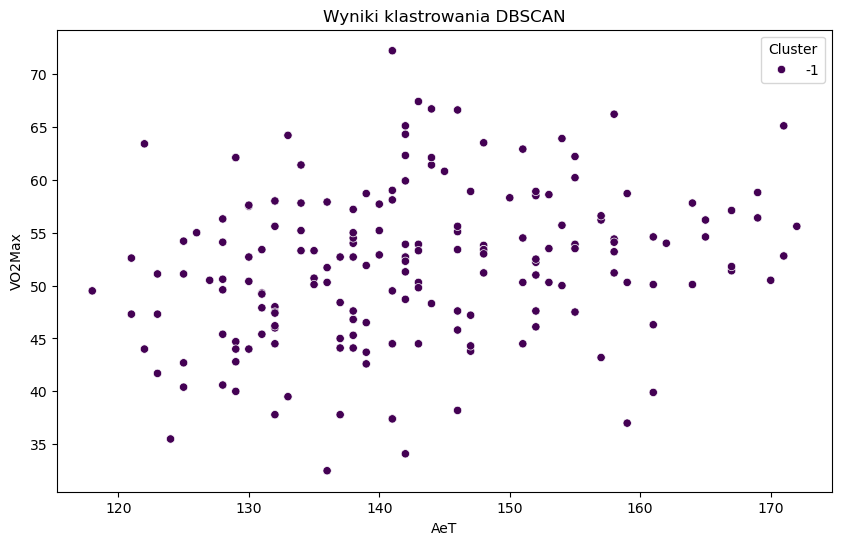

In [26]:
# Tworzenie wykresu wyników
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['AeT'], y=data['vo2max'], hue=data['Cluster'], palette='viridis', legend='full')
plt.title('Wyniki klastrowania DBSCAN')
plt.xlabel('AeT')
plt.ylabel('VO2Max')
plt.legend(title='Cluster')
plt.show()


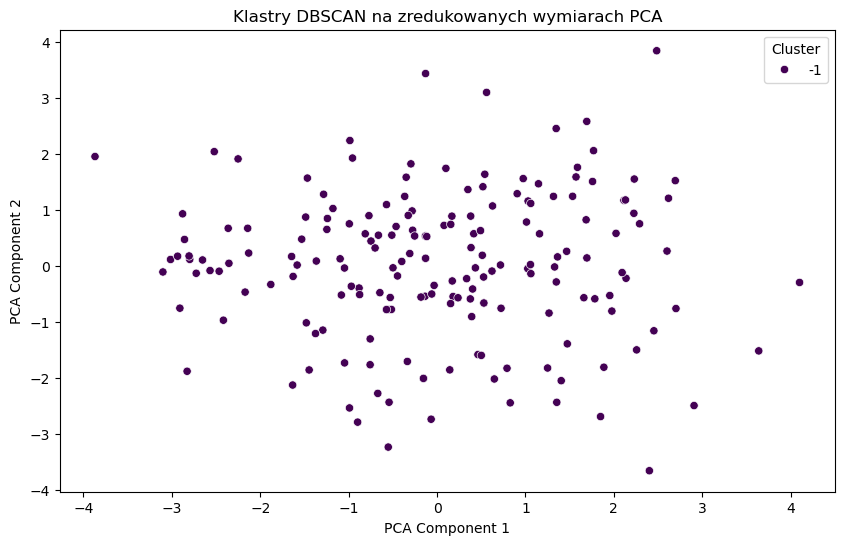

In [29]:
from sklearn.decomposition import PCA

# Redukcja wymiarów za pomocą PCA do 2D
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
data['PCA1'] = data_pca[:, 0]
data['PCA2'] = data_pca[:, 1]

# Wykres PCA z klastrami
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=data, palette='viridis')
plt.title('Klastry DBSCAN na zredukowanych wymiarach PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()
